In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random

In [2]:
import graphviz
from sklearn.utils import check_random_state
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

## Defining useful functions

In [3]:
#Function to change multiclass classification to 1 vs all
def multiclass_to_binary(labels, most_common_id):
    to_binary = lambda val: 1 if val == most_common_id else 0
    to_binary_vec = np.vectorize(to_binary)

    labels_1vsall = to_binary_vec(labels)

    return labels_1vsall

In [4]:
#Function for prettifying expressions output by the symbolic classifier (denoted as SR_Classifier)
#Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas

from sympy import *
from IPython.display import display, Math

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

def prettify(classifier):
    expression = sympify((str(SR_classifier._program)), locals=converter)
    exp_latek = latex(expression)
    ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    plt.text(0.4, 0.4,'$%s$'%exp_latek, size = 50)

    


## Pulling Full Sample Dataset from CSV and convert to np array

In [5]:
import os
path = os.getcwd()
par = os.path.abspath(os.path.join(path, os.pardir))

data_path = os.path.join(par,'3_generate_features','final_dimensionless_feature_array.csv')
label_path = os.path.join(par,'3_generate_features','final_label_array.csv')

os.path.isfile(data_path)


True

In [6]:
pd.set_option('display.max_columns', None)

In [47]:
#Turn into DF
prototype_df = pd.read_csv(data_path)

label_df = pd.read_csv(label_path)

#Drop formula column and bad column
prototype_df = prototype_df.drop(columns=['Unnamed: 0','e1_avg_oxi / e2_avg_oxi'])
prototype_df.head()

,e1_Number / e1_MendeleevNumber,e1_Number / e1_Column,e1_Number / e1_Row,e1_Number / e2_Number,e1_Number / e2_MendeleevNumber,e1_Number / e2_Column,e1_Number / e2_Row,e1_MendeleevNumber / e1_Column,e1_MendeleevNumber / e1_Row,e1_MendeleevNumber / e2_Number,e1_MendeleevNumber / e2_MendeleevNumber,e1_MendeleevNumber / e2_Column,e1_MendeleevNumber / e2_Row,e1_Column / e1_Row,e1_Column / e2_Number,e1_Column / e2_MendeleevNumber,e1_Column / e2_Column,e1_Column / e2_Row,e1_Row / e2_Number,e1_Row / e2_MendeleevNumber,e1_Row / e2_Column,e1_Row / e2_Row,e2_Number / e2_MendeleevNumber,e2_Number / e2_Column,e2_Number / e2_Row,e2_MendeleevNumber / e2_Column,e2_MendeleevNumber / e2_Row,e2_Column / e2_Row,e1_AtomicWeight / e2_AtomicWeight,e1_NsValence / e1_NpValence,e1_NsValence / e1_NdValence,e1_NsValence / e1_NfValence,e1_NsValence / e1_NValence,e1_NsValence / e1_NsUnfilled,e1_NsValence / e1_NpUnfilled,e1_NsValence / e1_NdUnfilled,e1_NsValence / e1_NfUnfilled,e1_NsValence / e1_NUnfilled,e1_NsValence / e2_NsValence,e1_NsValence / e2_NpValence,e1_NsValence / e2_NdValence,e1_NsValence / e2_NfValence,e1_NsValence / e2_NValence,e1_NsValence / e2_NsUnfilled,e1_NsValence / e2_NpUnfilled,e1_NsValence / e2_NdUnfilled,e1_NsValence / e2_NfUnfilled,e1_NsValence / e2_NUnfilled,e1_NpValence / e1_NdValence,e1_NpValence / e1_NfValence,e1_NpValence / e1_NValence,e1_NpValence / e1_NsUnfilled,e1_NpValence / e1_NpUnfilled,e1_NpValence / e1_NdUnfilled,e1_NpValence / e1_NfUnfilled,e1_NpValence / e1_NUnfilled,e1_NpValence / e2_NsValence,e1_NpValence / e2_NpValence,e1_NpValence / e2_NdValence,e1_NpValence / e2_NfValence,e1_NpValence / e2_NValence,e1_NpValence / e2_NsUnfilled,e1_NpValence / e2_NpUnfilled,e1_NpValence / e2_NdUnfilled,e1_NpValence / e2_NfUnfilled,e1_NpValence / e2_NUnfilled,e1_NdValence / e1_NfValence,e1_NdValence / e1_NValence,e1_NdValence / e1_NsUnfilled,e1_NdValence / e1_NpUnfilled,e1_NdValence / e1_NdUnfilled,e1_NdValence / e1_NfUnfilled,e1_NdValence / e1_NUnfilled,e1_NdValence / e2_NsValence,e1_NdValence / e2_NpValence,e1_NdValence / e2_NdValence,e1_NdValence / e2_NfValence,e1_NdValence / e2_NValence,e1_NdValence / e2_NsUnfilled,e1_NdValence / e2_NpUnfilled,e1_NdValence / e2_NdUnfilled,e1_NdValence / e2_NfUnfilled,e1_NdValence / e2_NUnfilled,e1_NfValence / e1_NValence,e1_NfValence / e1_NsUnfilled,e1_NfValence / e1_NpUnfilled,e1_NfValence / e1_NdUnfilled,e1_NfValence / e1_NfUnfilled,e1_NfValence / e1_NUnfilled,e1_NfValence / e2_NsValence,e1_NfValence / e2_NpValence,e1_NfValence / e2_NdValence,e1_NfValence / e2_NfValence,e1_NfValence / e2_NValence,e1_NfValence / e2_NsUnfilled,e1_NfValence / e2_NpUnfilled,e1_NfValence / e2_NdUnfilled,e1_NfValence / e2_NfUnfilled,e1_NfValence / e2_NUnfilled,e1_NValence / e1_NsUnfilled,e1_NValence / e1_NpUnfilled,e1_NValence / e1_NdUnfilled,e1_NValence / e1_NfUnfilled,e1_NValence / e1_NUnfilled,e1_NValence / e2_NsValence,e1_NValence / e2_NpValence,e1_NValence / e2_NdValence,e1_NValence / e2_NfValence,e1_NValence / e2_NValence,e1_NValence / e2_NsUnfilled,e1_NValence / e2_NpUnfilled,e1_NValence / e2_NdUnfilled,e1_NValence / e2_NfUnfilled,e1_NValence / e2_NUnfilled,e1_NsUnfilled / e1_NpUnfilled,e1_NsUnfilled / e1_NdUnfilled,e1_NsUnfilled / e1_NfUnfilled,e1_NsUnfilled / e1_NUnfilled,e1_NsUnfilled / e2_NsValence,e1_NsUnfilled / e2_NpValence,e1_NsUnfilled / e2_NdValence,e1_NsUnfilled / e2_NfValence,e1_NsUnfilled / e2_NValence,e1_NsUnfilled / e2_NsUnfilled,e1_NsUnfilled / e2_NpUnfilled,e1_NsUnfilled / e2_NdUnfilled,e1_NsUnfilled / e2_NfUnfilled,e1_NsUnfilled / e2_NUnfilled,e1_NpUnfilled / e1_NdUnfilled,e1_NpUnfilled / e1_NfUnfilled,e1_NpUnfilled / e1_NUnfilled,e1_NpUnfilled / e2_NsValence,e1_NpUnfilled / e2_NpValence,e1_NpUnfilled / e2_NdValence,e1_NpUnfilled / e2_NfValence,e1_NpUnfilled / e2_NValence,e1_NpUnfilled / e2_NsUnfilled,e1_NpUnfilled / e2_NpUnfilled,e1_NpUnfilled / e2_NdUnfilled,e1_NpUnfilled / e2_NfUnfilled,e1_NpUnfilled / e2_NUnfilled,e1_NdUnfilled / e1_NfUnfilled,e1_NdUnfilled / e1_NUnfilled,e1_NdUnfilled / 

In [48]:
#Dataframe convert label into categorical variable for classification
#Then convert labels into numpy array
label_name = 'Prototype'
label_df[label_name]= pd.Categorical(label_df[label_name])
label_df['numeric_label'] = label_df[label_name].cat.codes

#Convert numerical dataframe column to array
labels = label_df['numeric_label'].to_numpy()

label_df.head()


,Prototype,numeric_label
0,Anatase#TiO2,18
1,Cristobalite#SiO2,114
2,Rutile#TiO2,298
3,Laves(2H)#MgZn2,201
4,Quartz(low)#SiO2,287


In [49]:
#Convert features to numpy
#Also define feature names for symbolic regression

features = prototype_df.to_numpy()
feature_names = list(prototype_df.columns)

In [50]:
#Find class frequencies
label_counts = label_df['numeric_label'].value_counts()
#See pandas categorical mapping
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))

label_counts[:5]




/var/folders/dj/nk2fdd2s5cl3c5mh7nkvr3040000gn/T/ipykernel_84734/3790179312.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  label_counts[:5]


203    1532
151     507
201     475
298     467
13      368
Name: numeric_label, dtype: int64

In [51]:
#Find class frequencies
#Inner expression label_df[]...index.tolist or ...values.tolist converts the value_counts index to both the index identifier as well as its value
#The index identifier is the label 
label_names_sorted = np.array(label_df['numeric_label'].value_counts().index.tolist())
label_values_sorted = np.array(label_df['numeric_label'].value_counts().values.tolist())

#Create overall labels array for ease of indexing
labels_array = np.transpose(np.stack([label_names_sorted, label_values_sorted]))

#See pandas categorical mapping to numbers
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))



In [52]:
#Define most class id of interest and relabel
id_ofinterest = labels_array[0,0]

labels_1vsall = multiclass_to_binary(labels, most_common_id=id_ofinterest)

## Applying Symbolic Regression


In [53]:
#Set rng seed and permutation of data examples for training
rng = check_random_state(5)

#Check number of dominant class examples
n_positive_class = np.sum(labels_1vsall)
#Dominant class boolean index
positive_class_mask = labels_1vsall==1

#Dominant class indexing to grab for training/test set (we want 50/50 representation)
SR_features_train = features[positive_class_mask,:]
SR_target_train = labels_1vsall[positive_class_mask]

#Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
SR_negative_train = features[~positive_class_mask,:]
SR_negative_target = labels_1vsall[~positive_class_mask]

#Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
negative_scrambled_order = rng.permutation(SR_negative_target.size)
subsample_idx = negative_scrambled_order[:n_positive_class]

#Concatenate an equal amount of negative training data to the list of positive training data so we have 50/50 class representation
SR_features = np.concatenate((SR_features_train, SR_negative_train[subsample_idx,:]),axis=0)
SR_targets = np.concatenate((SR_target_train, SR_negative_target[subsample_idx]), axis=0)

#Computing the estimated probabilities on the remainder of the negative set
remainder_negative_set_idx = negative_scrambled_order[n_positive_class:]

#Getting the rest of the negative set features and values
remainder_negative_features = SR_negative_train[remainder_negative_set_idx,:]
remainder_negative_targets = SR_negative_target[remainder_negative_set_idx]


In [54]:
number_of_nans_per_feature = np.sum(SR_features[SR_features > 100000],axis=0)

print(number_of_nans_per_feature)

0.0


In [55]:
#Generate 20-80 splits (we're going to just use one of these for the initial pass)

#The test/train split percentage is 1/n_splits : (n_splits-1) / n_splits
#E.g. for n_splits = 5, test/train split percentage is 20:80
skf = StratifiedKFold(n_splits=5) 
splits = skf.split(SR_features,SR_targets)

In [56]:
#Use first generator output for train/test splits
#Assign these indices as variables
(SR_train_idx, SR_test_idx) = next(splits)

In [57]:
#Defining train test splits using train/test indices
SR_features_train = SR_features[SR_train_idx]
SR_target_train = SR_targets[SR_train_idx]

SR_features_test = SR_features[SR_test_idx]
SR_target_test = SR_targets[SR_test_idx]


In [58]:
#Run Classifier
SR_classifier = SymbolicClassifier(population_size = 1000, # number of expressions per generation
                        generations=40, # number of tournaments
                         tournament_size = 30, # number of expressions in tournament - higher = less expression diversity
                         parsimony_coefficient=0.0003, # penalty for expression length - higher value = shorter expressions 
                         p_crossover = 0.85, # affects how expressions change over time
                         p_subtree_mutation = 0.01,
                         p_point_mutation = 0.01,
                         p_hoist_mutation = 0.1,
                         feature_names=feature_names,
						 random_state=1)

SR_classifier.fit(SR_features_train, SR_target_train)

SymbolicClassifier(feature_names=['e1_Number / e1_MendeleevNumber',
                                  'e1_Number / e1_Column', 'e1_Number / e1_Row',
                                  'e1_Number / e2_Number',
                                  'e1_Number / e2_MendeleevNumber',
                                  'e1_Number / e2_Column', 'e1_Number / e2_Row',
                                  'e1_MendeleevNumber / e1_Column',
                                  'e1_MendeleevNumber / e1_Row',
                                  'e1_MendeleevNumber / e2_Number',
                                  'e1_MendeleevNumber / e2_MendeleevNumber',
                                  'e1_MendeleevNumber /...
                                  'e1_Row / e2_Column', 'e1_Row / e2_Row',
                                  'e2_Number / e2_MendeleevNumber',
                                  'e2_Number / e2_Column', 'e2_Number / e2_Row',
                                  'e2_MendeleevNumber / e2_Column',
                                  'e2_MendeleevNumber / e2_Row',
                                  'e2_Column / e2_Row',
                                  'e1_AtomicWeight / e2_AtomicWeight',
                                  'e1_NsValence / e1_NpValence', ...],
                   generations=40, p_crossover=0.85, p_hoist_mutation=0.1,
                   parsimony_coefficient=0.0003, random_state=1,
                   tournament_size=30)

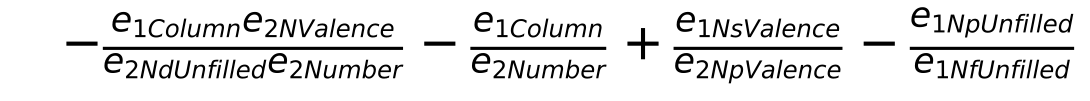

In [59]:
#Display prettified expression
prettify(SR_classifier)

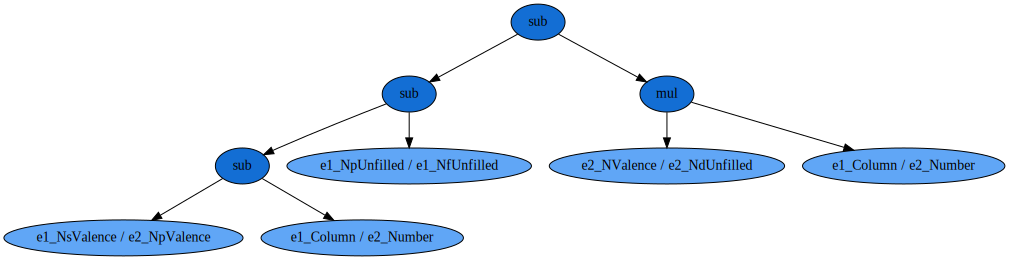

In [60]:
#Visualize as graph

dot_data = SR_classifier._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex4_tree', format='png', cleanup=True)
graph

In [64]:
predicted = SR_classifier.predict(SR_features_test)

print(precision_score(predicted,SR_target_test))
print(recall_score(predicted,SR_target_test))

0.9218241042345277
0.844776119402985


In [65]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict(remainder_negative_features)

# estimated_classes[:20]
print(precision_score(estimated_classes*-1+1, remainder_negative_targets*-1+1))
print(recall_score(estimated_classes*-1+1, remainder_negative_targets*-1+1))


0.8370865587614356
1.0


## Random Forest Benchmark

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
#Naive random forest
naive_rf = RandomForestClassifier(max_depth=5, n_estimators=10)
naive_rf.fit(SR_features_train,SR_target_train)



In [ ]:
#Stratified K fold (maintain class balance)

skf = StratifiedKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(skf.split(SR_features,SR_targets)):
    train_features_i = features[train_idx]
    train_labels_i = labels_1vsall[train_idx]

    test_features_i = features[test_idx]
    test_labels_i = labels_1vsall[test_idx]

    #Fit naive rf model
    naive_rf_i = RandomForestClassifier(max_depth=5, n_estimators=10)
    naive_rf_i.fit(train_features_i, train_labels_i)

    #Fit on k-folded validation set
    test_score_i = naive_rf_i.score(test_features_i, test_labels_i)

    print(f'Fold: {i}')
    print(f'Test: {test_score_i}')





In [ ]:
importances = naive_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in naive_rf.estimators_], axis = 0)


In [ ]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax=ax)
ax.set_title('Feature Importance MDI')
ax.set_ylabel('Mean decrease impurity')
fig.tight_layout()



In [ ]:
#TRIM THIS TOMORROW BASED ON FI 

## Cancer DSET (IGNORE THIS IS FOR REFERENCE)


In [ ]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

In [ ]:
cancer.feature_names


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt',
                'abs', 'neg', 'inv', 'max', 'min']

In [ ]:
#Defining function set to use in symbolic classification

est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

In [ ]:
a = sympify('mul(a,b)', locals=converter)
a

In [ ]:
est.hall_of_fame

In [ ]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)



In [ ]:
y_score